In [ ]:
import glob
from skimage import measure


ACKNOWLEDGEMENT
* https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
* https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/


In [ ]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In this notebook, we learn

* Loading DICOM data using pydicom

* Used 1D (histogram), 2D, and 3D plots to display DICOM images.
* Pre-processed data for future machine learning projects
* Conversion of pixel value to Hundsfeld units
* Resampling for isotropy
* normalization
* zero centering

Loading the files


Dicom is the de-facto file standard in medical imaging.  These files contain a lot of metadata (such as the pixel size, so how long one pixel is in every dimension in the real world).

This pixel size/coarseness of the scan differs from scan to scan (e.g. the distance between slices may differ), which can hurt performance of CNN approaches. We can deal with this by isomorphic resampling, which we will do later.


In [ ]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

In [ ]:
def myfunc(e):
    return e[-6:] 

In [ ]:
patient_list = train.Patient.unique()
data_path = '../input/osic-pulmonary-fibrosis-progression/train/'

patient = pd.DataFrame()
pid = []
count = []
path = []
for pat in patient_list:
    
    data_list = glob.glob(data_path + pat + '/*.dcm')
    data_list.sort(key=myfunc)
    pid.append(pat)
    path.append(data_list)
    count.append(len(data_list))
    
patient['pid']=pid
patient['path']= path
patient['count']=count

In [ ]:
patient.head()

In [ ]:
patient.path[0]

In [ ]:
slices = [pydicom.read_file(s) for s in patient.path[0]] #lets read metadeta of pydiacom file
print('The total no of ct scan associated with 1st patient',len(slices))
print(slices[3])

In [ ]:
slices.sort(key = lambda x: int(x.InstanceNumber)) # order the slice serially


Slice Thickness is a parameter that can be selected by the technologist.  This will change the thickness of our slice in millimeters.  By increasing the slice thickness, many more different types of tissues will be collected in our 2D slice.  This can cause blurring in our image also known as partial voluming.
Picture
Coverage

By increasing the slice thickness we will increase our coverage. 
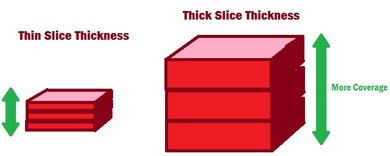

In [ ]:
slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
print(slice_thickness)

In [ ]:
#lets create a function for above task
def load_scan(path):
    slices = [pydicom.read_file(path +'/'+ s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices 


The unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this. From Wikipedia:

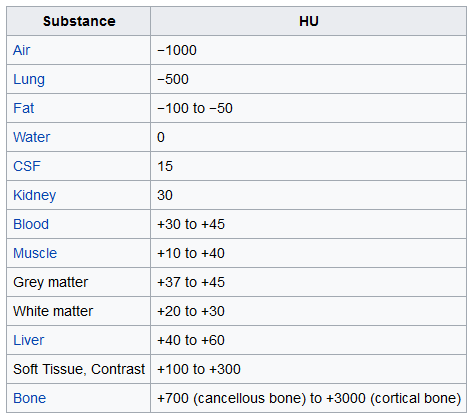

By default however, the returned values are not in this unit. Let's fix this.

Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

In [ ]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


In [ ]:
#lets take alook at patient
patient = load_scan('../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430')
imgs = get_pixels_hu(patient)
plt.hist(imgs.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


plt.imshow(imgs[29], cmap=plt.cm.gray)
plt.show()


# Resampling

A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.

Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while.

Below code worked well for us (and deals with the edge cases):

In [ ]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) "% (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Although we have each individual slices, it is not immediately clear how thick each slice is.

Slice Thickness: 10.000000
Pixel Spacing (row, col): (0.652344, 0.652344) 
This means we have 10.00 mm slices, and each voxel represents 0.652344 mm.

Because a CT slice is typically reconstructed at 512 x 512 voxels, each slice represents approximately 370 mm of data in length and width.

Using the metadata from the DICOM we can figure out the size of each voxel as the slice thickness. In order to display the CT in 3D isometric form (which we will do below), and also to compare between different scans, it would be useful to ensure that each slice is resampled in 1x1x1 mm pixels and slices.

In [ ]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [ ]:
pix_resampled, spacing = resample(imgs, patient, [1,1,1])
print("Shape before resampling\t", imgs.shape)
print("Shape after resampling\t", pix_resampled.shape)

In [ ]:
plt.hist(pix_resampled.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


plt.imshow(imgs[29], cmap=plt.cm.gray)
plt.show()

   
# 3D Plotting

In [ ]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    
    p = image.transpose(2,1,0) #get image in order(h,w,c)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [ ]:
plot_3d(pix_resampled, 400)


# Normalization

Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity. A commonly used set of thresholds in the LUNA16 competition to normalize between are -1000 and 400. Here's some code you can use:

In [ ]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

# Zero centering

As a final preprocessing step, it is advisory to zero center your data so that your mean value is 0. To do this you simply subtract the mean pixel value from all pixels.

To determine this mean you simply average all images in the whole dataset. If that sounds like a lot of work, we found this to be around 0.25 in the LUNA16 competition.

Warning: Do not zero center with the mean per image (like is done in some kernels on here). The CT scanners are calibrated to return accurate HU measurements. There is no such thing as an image with lower contrast or brightness like in normal pictures.

In [ ]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

With these steps your images are ready for consumption by your CNN or other ML method 